## TODO

- PDF of CSAT plots
- HPA validation and expression levels
- move data loading and plotting to .py file

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator

from plotting import violinplot_reflected
from data_loading import load_ref_vs_alt_isoforms_table

In [2]:
pd.set_option('display.max_columns', 200)

In [3]:
from data_loading import DATA_DIR

def load_condensate_data():
    """
    Reference vs alternative isoforms table with additional info
    about condensates, restricted to pairs that were tested in the
    condensates assay.
    """
    df = pd.read_excel(DATA_DIR / 'internal/TFiso_LLPS_scores_20231215.xlsx')
    df['gene_symbol'] = df['isoform_acc'].map(lambda x: x.split('|')[0])
    df['condensates_observed_HEK'] = (df['LLPS_HEK293'] != 0)
    df['condensates_observed_U2OS'] = (df['LLPS_U2OS'] != 0)
    df['is_cloned_reference'] = df['Ref_isoform'].map({'Reference': True,
                                                    'Alternative': False})
    df = df.rename(columns={'LLPS_HEK293': 'HEK_Condensate',
                            'LLPS_U2OS': 'U2OS_Condensate',
                            'Localization_U2OS': 'localization_U2OS',
                            })
    df['HEK_Condensate'] = df['HEK_Condensate'].map(
        lambda x: {
            'cc/nm': 'BOTH',
            'few nc': 'NC',
            'few cc': 'CC',
                }.get(x, x)).str.strip().str.upper()
    df['U2OS_Condensate'] = df['U2OS_Condensate'].map(
        lambda x: {
            'cc/nm': 'BOTH',
            'few nc': 'NC',
            'few cc': 'CC',
                }.get(x, x)).str.strip().str.upper()
    rename_loc = {'mostly in nucleus': 'both',
                'in nucleus': 'nucleus'}
    for cl in ['HEK', 'U2OS']:
        df[f'localization_{cl}'] = (df[f'localization_{cl}']
                                    .str.strip()
                                    .str.lower()
                                    .map(lambda x: rename_loc.get(x, x))
        )
    if df['isoform_acc'].duplicated().any():
        raise UserWarning('unexpected duplicates')
    df = df.set_index('isoform_acc')

    pairs = load_ref_vs_alt_isoforms_table()
    pairs.loc[(pairs['n_positive_PPI_ref'] == 0) | (pairs['n_positive_PPI_alt'] == 0),
            'PPI_jaccard'] = np.nan
    pairs['PPI_Jaccard_d'] = 1 - pairs['PPI_jaccard']
    pairs['PDI_Jaccard_d'] = 1 - pairs['PDI_jaccard']
    for x in ['ref', 'alt']:
        for var in ['condensates_observed_HEK',
                    'condensates_observed_U2OS',
                    'HEK_Condensate',
                    'U2OS_Condensate', 
                    'localization_HEK',
                    'localization_U2OS',
                    ]:
            pairs[var + '_' + x] = pairs['clone_acc_' + x].map(df[var])

    # Only take pairs with condensate info    
    pairs = pairs.loc[pairs['condensates_observed_HEK_ref'].notnull()
                      & pairs['condensates_observed_HEK_alt'].notnull(), :]

    for cl in ['HEK', 'U2OS']:
        pairs.loc[:, f'condensate_cat_{cl}'] = 'Unchanged'
        pairs.loc[pairs[f'{cl}_Condensate_ref'].notnull()
                & pairs[f'{cl}_Condensate_alt'].isnull(), 
                f'condensate_cat_{cl}'] = 'LOC'
        pairs.loc[pairs[f'{cl}_Condensate_ref'].isnull()
                & pairs[f'{cl}_Condensate_alt'].notnull(), 
                f'condensate_cat_{cl}'] = 'GOC'
        pairs.loc[((pairs[f'{cl}_Condensate_ref'] == 'NC')
                & (pairs[f'{cl}_Condensate_alt'] == 'CC'))
                |
                ((pairs[f'{cl}_Condensate_ref'] == 'CC')
                    & (pairs[f'{cl}_Condensate_alt'] == 'NC')),
                f'condensate_cat_{cl}'] = 'Changed localization'
    pairs['condensate_cat_merged_HEK'] = pairs['condensate_cat_HEK'].map({
        'Unchanged': 'No difference',
        'LOC': 'Difference',
        'GOC': 'Difference',
        'Changed localization': 'Difference',
        })
    pairs['condensate_cat_merged_U2OS'] = pairs['condensate_cat_U2OS'].map({
        'Unchanged': 'No difference',
        'LOC': 'Difference',
        'GOC': 'Difference',
        'Changed localization': 'Difference',
        })
    return pairs, df

pairs, df = load_condensate_data()

In [42]:
for cl in ['HEK', 'U2OS']:
    pairs[f'condensate_cat_only_{cl}'] = pairs[f'condensate_cat_{cl}'].map(
        {
            'Unchanged': 'No difference',
            'LOC': 'Difference',
            'GOC': 'Difference',
            'Changed localization': 'No difference',
        }
    )

for cl in ['HEK', 'U2OS']:
    var = f'localization_cat_{cl}'
    pairs[var] = np.nan
    pairs.loc[pairs[f'localization_{cl}_ref'] == pairs[f'localization_{cl}_alt'], var] = 'No difference'
    pairs.loc[pairs[f'localization_{cl}_ref'] != pairs[f'localization_{cl}_alt'], var] = 'Difference'
    if pairs[var].isnull().any():
        raise UserWarning('bug in code')
    
for cl in ['HEK', 'U2OS']:
    pairs[f'condensate_cat_only_detailed_{cl}'] = pairs[f'condensate_cat_{cl}'].map(
        {
        'Unchanged': 'Both form condensates',
        'LOC': 'Alternative loses condensate',
        'GOC': 'Alernative gains condensate',
        'Changed localization': 'Both form condensates',
    })
    pairs.loc[(pairs[f'condensates_observed_{cl}_ref'] == False)
            & (pairs[f'condensates_observed_{cl}_alt'] == False),
            f'condensate_cat_only_detailed_{cl}'] = 'Neither form condensates'
for cl in ['HEK', 'U2OS']:
    pairs[f'condensate_or_loc_change_{cl}'] = (
        (pairs[f'condensates_observed_{cl}_ref'] == pairs[f'condensates_observed_{cl}_alt'])
        & (pairs[f'localization_{cl}_ref'] == pairs[f'localization_{cl}_alt'])
    ).map({True: 'No difference', False: 'Difference'})
for cl in ['HEK', 'U2OS']:
    c = f'combined_cat_{cl}'
    pairs[c] = np.nan
    diff_loc = pairs[f'localization_{cl}_ref'] != pairs[f'localization_{cl}_alt']
    diff_cond = pairs[f'condensates_observed_{cl}_ref'] != pairs[f'condensates_observed_{cl}_alt']
    pairs.loc[diff_loc & ~diff_cond, c] = 'Difference in localization' 
    pairs.loc[~diff_loc & diff_cond, c] = 'Difference in condensate formation'
    pairs.loc[diff_loc & diff_cond, c] = 'Difference in both'
    pairs.loc[~diff_loc & ~diff_cond, c] = 'Same localization and condensate formation'
    if pairs[c].isnull().any():
        raise UserWarning('Bug in code')
pairs['condensate_cat_only_both'] = pairs['condensate_cat_only_HEK']
pairs.loc[pairs['condensate_cat_only_HEK'] != pairs['condensate_cat_only_U2OS'],
          'condensate_cat_only_both'] = np.nan
pairs['condensate_or_loc_change_both'] = pairs['condensate_or_loc_change_HEK']
pairs.loc[pairs['condensate_or_loc_change_HEK'] != pairs['condensate_or_loc_change_U2OS'],
          'condensate_or_loc_change_both'] = np.nan


def detailed_condensate_cat(row, cl):
    a = row[f'{cl}_Condensate_ref']
    if pd.isnull(a):
        a = 'None'
    b = row[f'{cl}_Condensate_alt']
    if pd.isnull(b):
        b = 'None'
    return '{} -> {}'.format(a, b)

for cl in ['HEK', 'U2OS']:
    pairs[f'condensate_cat_detailed_{cl}'] = pairs.apply(detailed_condensate_cat, cl=cl, axis=1)

In [38]:
print(pairs['clone_acc_ref'].nunique() + pairs['clone_acc_alt'].nunique(),
      'isoforms, of',
      pairs['gene_symbol'].nunique(),
      'genes, successfully tested for condensate formation')

189 isoforms, of 60 genes, successfully tested for condensate formation


In [5]:
pairs.iloc[:5, -16:]

,condensate_cat_merged_U2OS,condensate_cat_only_HEK,condensate_cat_only_U2OS,localization_cat_HEK,localization_cat_U2OS,condensate_cat_only_detailed_HEK,condensate_cat_only_detailed_U2OS,condensate_or_loc_change_HEK,condensate_or_loc_change_U2OS,combined_cat_HEK,combined_cat_U2OS,condensate_cat_only_both,condensate_change_both,condensate_or_loc_change_both,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS
0,No difference,No difference,No difference,No difference,No difference,Both form condensates,Both form condensates,No difference,No difference,Same localization and condensate formation,Same localization and condensate formation,No difference,No difference,NaN,BOTH -> NC,BOTH -> BOTH
1,Difference,Difference,Difference,Difference,No difference,Alternative loses condensate,Alternative loses condensate,Difference,Difference,Difference in both,Difference in condensate formation,Difference,Difference,NaN,NC -> None,NC -> None
2,No difference,Difference,No difference,No difference,No difference,Alternative loses condensate,Both form condensates,Difference,No difference,Difference in condensate formation,Same localization and condensate formation,NaN,Difference,NaN,NC -> None,NC -> NC
5,No difference,No difference,No difference,No difference,Difference,Both form condensates,Both form condensates,No difference,Difference,Same localization and condensate formation,Difference in localization,No difference,No difference,NaN,NC -> BOTH,NC -> BOTH
6,No difference,No difference,No difference,No difference,Difference,Both form condensates,Both form condensates,No difference,Difference,Same localization and condensate formation,Difference in localization,No difference,No difference,NaN,NC -> BOTH,NC -> BOTH


In [41]:
# DEBUG
pairs['condensate_or_loc_change_HEK'] != pairs['condensate_or_loc_change_U2OS']

0      False
1      False
2       True
5       True
6       True
       ...  
431     True
432    False
433     True
438    False
439     True
Length: 129, dtype: bool

In [6]:
# compare condensate across 2 cell lines
(df.fillna('NONE')
 .groupby(['HEK_Condensate', 'U2OS_Condensate'])
 .size()
 .reset_index()
 .pivot(values=0,
        index='HEK_Condensate',
        columns='U2OS_Condensate')
 .fillna(0)
 .astype(int)
 .iloc[::-1, ::-1]
        )

U2OS_Condensate,NONE,NC,CC,BOTH
HEK_Condensate,,,,
NONE,32,4,2,2
NC,1,35,0,7
CC,4,4,47,15
BOTH,0,7,2,27


In [7]:
def table_circle_size_plot(df, ax=None, scale=3000, fontsize=12):
    if ax is None:
        ax = plt.gca()
    scale_factor = scale / df.sum().sum()
    ax.scatter(x=[j for i in range(df.shape[0]) for j in range(df.shape[1])],
               y=[i for i in range(df.shape[0]) for j in range(df.shape[1])],
               s=df.values.flatten() * scale_factor,
               clip_on=False,
               )
    # write numbers
    for i in range(df.shape[0]):
        for j in range(df.shape[1]):
            ax.text(
                s=df.values[i, j],
                x=j,
                y=i,
                ha='center',
                va='center',
                fontsize=fontsize,
                color='white',
            )
    ax.set_xticks(range(df.shape[1]))
    ax.set_yticks(range(df.shape[0]))
    ax.set_xlabel(df.columns.name)
    ax.set_ylabel(df.index.name)
    ax.set_xticklabels(df.columns.values, rotation=45, ha='right')
    ax.set_yticklabels(df.index.values)
    ax.set_xlim(-0.5, df.shape[1] - 0.5)
    ax.set_ylim(df.shape[0] - 0.5, -0.5)  # NOTE: flipping axis
    ax.set_aspect('equal')
    ax.xaxis.set_tick_params(length=0)
    ax.yaxis.set_tick_params(length=0)
    for loc in ['left', 'right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)

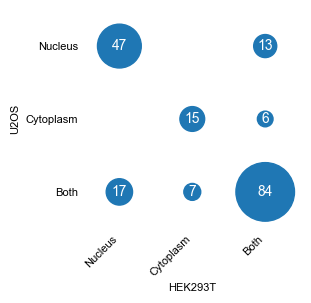

In [8]:
tbl = (df.groupby(['localization_HEK', 'localization_U2OS'])
 .size()
 .reset_index()
 .pivot(values=0,
        index='localization_HEK',
        columns='localization_U2OS')
 .fillna(0)
 .astype(int)
 .iloc[::-1, ::-1]
        )

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 3)
table_circle_size_plot(tbl, ax=ax, scale=4000, fontsize=10)
ax.set_ylabel('U2OS')
ax.set_xlabel('HEK293T')
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()])
ax.set_yticklabels([x.get_text().capitalize() for x in ax.get_yticklabels()])
fig.savefig('../figures/localization_HEK-vs-U2OS_diff-cat_circle-plot.pdf', bbox_inches='tight')

In [9]:
tbl = (pairs.groupby(['condensate_cat_HEK', 'condensate_cat_U2OS'])
 .size()
 .reset_index()
 .pivot(values=0,
        index='condensate_cat_HEK',
        columns='condensate_cat_U2OS')
 .fillna(0)
 .astype(int)
 .iloc[::-1, ::-1]
        )
tbl

condensate_cat_U2OS,Unchanged,LOC,GOC,Changed localization
condensate_cat_HEK,,,,
Unchanged,70,3,2,4
LOC,4,14,0,1
GOC,9,0,7,0
Changed localization,4,1,0,10


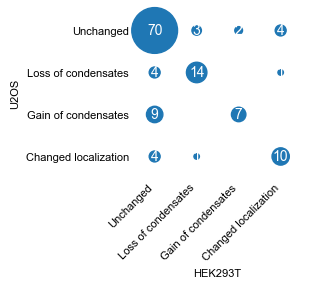

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(3, 3)
table_circle_size_plot(tbl, ax=ax, scale=2000, fontsize=10)
ax.set_ylabel('U2OS')
ax.set_xlabel('HEK293T')
rename_cats = {
    'LOC': 'Loss of condensates',
    'GOC': 'Gain of condensates',
}
ax.set_xticklabels([rename_cats.get(x.get_text(), x.get_text()) for x in ax.get_xticklabels()])
ax.set_yticklabels([rename_cats.get(x.get_text(), x.get_text()) for x in ax.get_yticklabels()])
fig.savefig('../figures/condensate_HEK-vs-U2OS_diff-cat_circle-plot.pdf', bbox_inches='tight')

In [11]:
tbl = (pairs.groupby(['condensate_cat_merged_HEK', 'condensate_cat_merged_U2OS'])
 .size()
 .reset_index()
 .pivot(values=0,
        index='condensate_cat_merged_HEK',
        columns='condensate_cat_merged_U2OS')
 .fillna(0)
 .astype(int)
 .iloc[::-1, ::-1]
        )
tbl

condensate_cat_merged_U2OS,No difference,Difference
condensate_cat_merged_HEK,,
No difference,70,9
Difference,17,33


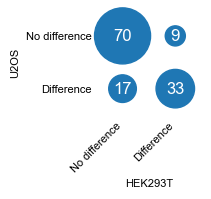

In [12]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
table_circle_size_plot(tbl, ax=ax, scale=3000)
ax.set_ylabel('U2OS')
ax.set_xlabel('HEK293T')
fig.savefig('../figures/condensate_HEK-vs-U2OS_diff-vs-no_circle-plot.pdf', bbox_inches='tight')

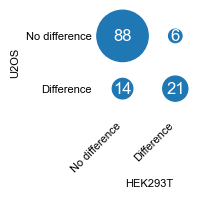

In [13]:
tbl = (pairs.groupby(['condensate_cat_only_HEK', 'condensate_cat_only_U2OS'])
 .size()
 .reset_index()
 .pivot(values=0,
        index='condensate_cat_only_HEK',
        columns='condensate_cat_only_U2OS')
 .fillna(0)
 .astype(int)
 .iloc[::-1, ::-1]
        )

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(2, 2)
table_circle_size_plot(tbl, ax=ax, scale=2000)
ax.set_ylabel('U2OS')
ax.set_xlabel('HEK293T')
fig.savefig('../figures/condensate_only_HEK-vs-U2OS_diff-vs-no_circle-plot.pdf', bbox_inches='tight')

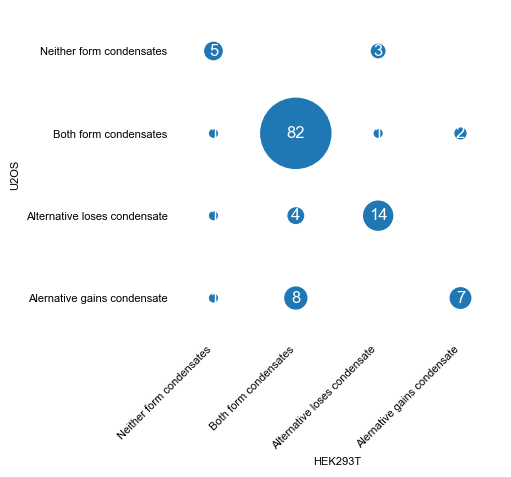

In [14]:
tbl = (pairs.groupby(['condensate_cat_only_detailed_HEK', 'condensate_cat_only_detailed_U2OS'])
 .size()
 .reset_index()
 .pivot(values=0,
        index='condensate_cat_only_detailed_HEK',
        columns='condensate_cat_only_detailed_U2OS')
 .fillna(0)
 .astype(int)
 .iloc[::-1, ::-1]
        )

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 5)
table_circle_size_plot(tbl, ax=ax, scale=4000)
ax.set_ylabel('U2OS')
ax.set_xlabel('HEK293T')
fig.savefig('../figures/condensate_only_detailed_HEK-vs-U2OS_diff-vs-no_circle-plot.pdf', bbox_inches='tight')

In [15]:
pairs.loc[pairs['condensate_cat_HEK'] == 'Changed localization', 
          :,].groupby(['HEK_Condensate_ref', 'HEK_Condensate_alt']).size()

HEK_Condensate_ref  HEK_Condensate_alt
CC                  NC                     3
NC                  CC                    12
dtype: int64

In [16]:
pairs.loc[pairs['condensate_cat_U2OS'] == 'Changed localization', 
          :,].groupby(['U2OS_Condensate_ref', 'U2OS_Condensate_alt']).size()

U2OS_Condensate_ref  U2OS_Condensate_alt
CC                   NC                      4
NC                   CC                     11
dtype: int64

In [17]:
print('tested {} isoforms of {} TF genes'.format(df.index.nunique(),
                    df['gene_symbol'].nunique())
    )
for cl in ['HEK', 'U2OS']:
    print(f'in {cl} cells:')
    print('{} ({:.0%}) reference isoforms show condensates'.format(
        df.loc[df['is_cloned_reference'], f'condensates_observed_{cl}'].sum(),
        df.loc[df['is_cloned_reference'], f'condensates_observed_{cl}'].mean()))
    print('{} ({:.0%}) alternative isoforms show condensates'.format(
        df.loc[~df['is_cloned_reference'], f'condensates_observed_{cl}'].sum(),
        df.loc[~df['is_cloned_reference'], f'condensates_observed_{cl}'].mean()))
    print('{} ({:.0%}) alternative isoforms change condensate formation compared to reference'.format(
        (pairs[f'condensate_cat_{cl}'] != 'Unchanged').sum(),
        (pairs[f'condensate_cat_{cl}'] != 'Unchanged').mean()))

    print()
    print(pairs[f'condensate_cat_{cl}'].value_counts())
    print()



tested 189 isoforms of 60 TF genes
in HEK cells:
47 (78%) reference isoforms show condensates
102 (79%) alternative isoforms show condensates
50 (39%) alternative isoforms change condensate formation compared to reference

Unchanged               79
LOC                     19
GOC                     16
Changed localization    15
Name: condensate_cat_HEK, dtype: int64

in U2OS cells:
49 (82%) reference isoforms show condensates
103 (80%) alternative isoforms show condensates
42 (33%) alternative isoforms change condensate formation compared to reference

Unchanged               87
LOC                     18
Changed localization    15
GOC                      9
Name: condensate_cat_U2OS, dtype: int64



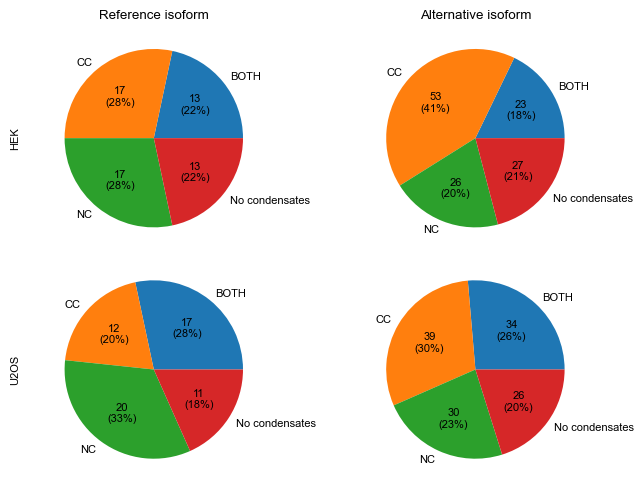

In [18]:
fig, axs = plt.subplots(nrows=2, ncols=2)
for i, cl in enumerate(['HEK', 'U2OS']):
    n = df['is_cloned_reference'].sum()
    (
        df.loc[df['is_cloned_reference'], f'{cl}_Condensate']
        .fillna('No condensates')
        .value_counts()
        .sort_index()
        .plot.pie(autopct=lambda x: '{:.0f}\n({:.0f}%)'.format(x / 100 * n, x),
    ax=axs[i, 0])
    )
    n = (~df['is_cloned_reference']).sum()
    (
        df.loc[~df['is_cloned_reference'], f'{cl}_Condensate']
        .fillna('No condensates')
        .value_counts()
        .sort_index()
        .plot.pie(autopct=lambda x: '{:.0f}\n({:.0f}%)'.format(x / 100 * n, x),
    ax=axs[i, 1])
    )
axs[0, 0].set_title('Reference isoform')
axs[0, 1].set_title('Alternative isoform')
axs[0, 0].text(s='HEK', x=-1.5, y=0, rotation=90, ha='right', va='center')
axs[1, 0].text(s='U2OS', x=-1.5, y=0, rotation=90, ha='right', va='center')
for ax in axs.flatten():
    ax.set_ylabel('')
fig.savefig('../figures/condensate-localisation_ref-vs-alt_pie.pdf',
            bbox_inches='tight')

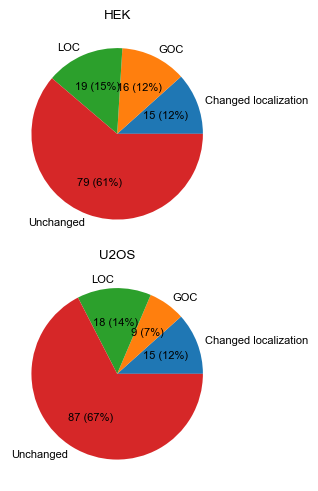

In [19]:
fig, axs = plt.subplots(nrows=2, ncols=1)
n = (~df['is_cloned_reference']).sum()
(pairs['condensate_cat_HEK']
 .value_counts()
 .sort_index()
 .plot.pie(autopct=lambda x: '{:.0f} ({:.0f}%)'.format(x / 100 * n, x),
 ax=axs[0]))
(pairs['condensate_cat_U2OS']
 .value_counts()
 .sort_index()
 .plot.pie(autopct=lambda x: '{:.0f} ({:.0f}%)'.format(x / 100 * n, x),
 ax=axs[1]))
for ax in axs:
    ax.set_ylabel('')
axs[0].set_title('HEK')
axs[1].set_title('U2OS')
#ax.set_title('Differences in alternative isoforms')
fig.savefig('../figures/condensate-change-categories_pie.pdf',
            bbox_inches='tight')

In [20]:
pairs.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_identity,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,activation_abs_fold_change_log2,PPI_Jaccard_d,PDI_Jaccard_d,condensates_observed_HEK_ref,condensates_observed_U2OS_ref,HEK_Condensate_ref,U2OS_Condensate_ref,localization_HEK_ref,localization_U2OS_ref,condensates_observed_HEK_alt,condensates_observed_U2OS_alt,HEK_Condensate_alt,U2OS_Condensate_alt,localization_HEK_alt,localization_U2OS_alt,condensate_cat_HEK,condensate_cat_U2OS,condensate_cat_merged_HEK,condensate_cat_merged_U2OS,condensate_cat_only_HEK,condensate_cat_only_U2OS,localization_cat_HEK,localization_cat_U2OS,condensate_cat_only_detailed_HEK,condensate_cat_only_detailed_U2OS,condensate_or_loc_change_HEK,condensate_or_loc_change_U2OS,combined_cat_HEK,combined_cat_U2OS,condensate_cat_only_both,condensate_change_both,condensate_or_loc_change_both,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.0,False,98.116761,4.0,4.0,5.0,4.0,4.0,3.0,2.0,0.0,0.6,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.0,True,2.153413,2.656826,0.503414,0.503414,0.4,1.0,True,True,BOTH,BOTH,both,both,True,True,NC,BOTH,both,both,Unchanged,Unchanged,No difference,No difference,No difference,No difference,No difference,No difference,Both form condensates,Both form condensates,No difference,No difference,Same localization and condensate formation,Same localization and condensate formation,No difference,No difference,NaN,BOTH -> NC,BOTH -> BOTH
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.0,False,82.040816,0.0,13.0,13.0,0.0,13.0,0.0,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,0.872271,NaN,NaN,True,True,NC,NC,nucleus,nucleus,False,False,NaN,NaN,both,nucleus,LOC,LOC,Difference,Difference,Difference,Difference,Difference,No difference,Alternative loses condensate,Alternative loses condensate,Difference,Difference,Difference in both,Difference in condensate formation,Difference,Difference,NaN,NC -> None,NC -> None
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.0,False,81.224490,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,9.0,9.0,9.0,9.0,9.0,1.0,True,1.552087,0.773129,-0.778958,0.778958,NaN,0.0,True,True,NC,NC,nucleus,nucleus,False,True,NaN,NC,nucleus,nucleus,LOC,Unchanged,Difference,No difference,Difference,No difference,No difference,No difference,Alternative loses condensate,Both form condensates,Difference,No difference,Difference in condensate formation,Same localization and condensate formation,NaN,Difference,NaN,NC -> None,NC -> NC
5,GRHL3,ENSG0000

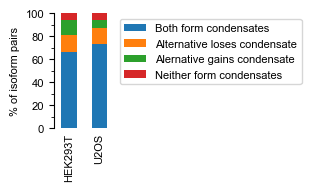

In [21]:
f = pd.concat(
        [pairs['condensate_cat_only_detailed_HEK'].value_counts().to_frame().T,
        pairs['condensate_cat_only_detailed_U2OS'].value_counts().to_frame().T,]
)
if f.sum(axis=1).nunique() > 1:
    raise UserWarning('expected identical numbers for both cell lines')
f = f / f.sum(axis=1).iloc[0] * 100
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3, h=1.8)
f.plot.bar(stacked=True, 
           ax=ax)
for pos in ['top', 'bottom', 'right']:
    ax.spines[pos].set_visible(False)
ax.set_xticklabels(['HEK293T', 'U2OS'])
ax.xaxis.set_tick_params(length=0)
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticks(range(0, 101, 10), minor=True)
ax.set_ylabel('% of isoform pairs')
ax.legend(bbox_to_anchor=(1, 1))
fig.savefig('../figures/condensate-difference_stacked-bar.pdf',
            bbox_inches='tight')

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_59069/649800046.py:27: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig('../figures/localization-difference_stacked-bar.pdf',
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


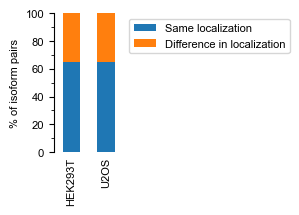

In [22]:
f = pd.concat(
        [(pairs['localization_HEK_ref'] == pairs['localization_HEK_alt'])
         .map({True: 'Same localization',
               False: 'Difference in localization'})
         .value_counts().to_frame().T,
        (pairs['localization_U2OS_ref'] == pairs['localization_U2OS_alt'])
         .map({True: 'Same localization',
               False: 'Difference in localization'})
        .value_counts().to_frame().T,]
)
if f.sum(axis=1).nunique() > 1:
    raise UserWarning('expected identical numbers for both cell lines')
f = f / f.sum(axis=1).iloc[0] * 100
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=0.9, h=1.8)
f.plot.bar(stacked=True, 
           ax=ax)
for pos in ['top', 'bottom', 'right']:
    ax.spines[pos].set_visible(False)
ax.set_xticklabels(['HEK293T', 'U2OS'])
ax.xaxis.set_tick_params(length=0)
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticks(range(0, 101, 10), minor=True)
ax.set_ylabel('% of isoform pairs')
ax.legend(bbox_to_anchor=(1, 1))
fig.savefig('../figures/localization-difference_stacked-bar.pdf',
            bbox_inches='tight')

In [23]:
pairs['condensates_observed_HEK_alt'].value_counts(dropna=False)

True     102
False     27
Name: condensates_observed_HEK_alt, dtype: int64

/var/folders/4f/st3pbvs10sd68jl3b4p861h80000gn/T/ipykernel_59069/1666506700.py:21: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.savefig('../figures/localization-and-condensate-difference_stacked-bar.pdf',
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)
/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  fig.canvas.print_figure(bytes_io, **kw)


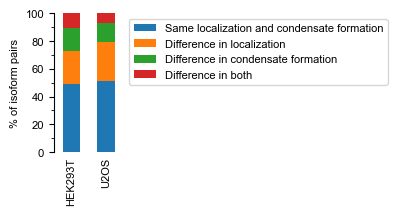

In [24]:
f = pd.concat(
        [pairs['combined_cat_HEK'].value_counts().to_frame().T,
        pairs['combined_cat_U2OS'].value_counts().to_frame().T,]
)
if f.sum(axis=1).nunique() > 1:
    raise UserWarning('expected identical numbers for both cell lines')
f = f / f.sum(axis=1).iloc[0] * 100
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=0.9, h=1.8)
f.plot.bar(stacked=True, 
           ax=ax)
for pos in ['top', 'bottom', 'right']:
    ax.spines[pos].set_visible(False)
ax.set_xticklabels(['HEK293T', 'U2OS'])
ax.xaxis.set_tick_params(length=0)
ax.set_ylim(0, 100)
ax.set_yticks(range(0, 101, 20))
ax.set_yticks(range(0, 101, 10), minor=True)
ax.set_ylabel('% of isoform pairs')
ax.legend(bbox_to_anchor=(1, 1))
fig.savefig('../figures/localization-and-condensate-difference_stacked-bar.pdf',
            bbox_inches='tight')

In [25]:
print('all:')
print(df['HEK_Condensate'].value_counts())
print('\nreference:')
print(df.loc[df['is_cloned_reference'], 'HEK_Condensate'].value_counts())
print('\nalternative')
print(df.loc[~df['is_cloned_reference'], 'HEK_Condensate'].value_counts())

all:
CC      70
NC      43
BOTH    36
Name: HEK_Condensate, dtype: int64

reference:
CC      17
NC      17
BOTH    13
Name: HEK_Condensate, dtype: int64

alternative
CC      53
NC      26
BOTH    23
Name: HEK_Condensate, dtype: int64


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.182


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


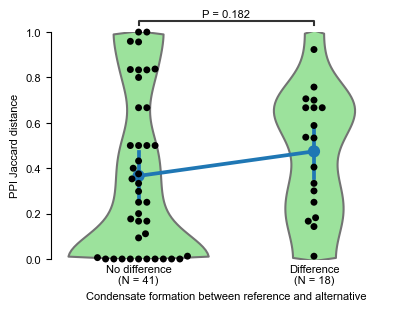

In [45]:
def Welchs_t_statistic(x, y):
    denom = np.sqrt(x.var() / len(x) + y.var() / len(y))
    return (x.mean() - y.mean()) / denom


def permutation_test(x, y):
    """
    two-sided
    """
    nx = x.shape[0]
    ny = y.shape[0]
    #obs = x.mean() - y.mean()
    obs = Welchs_t_statistic(x, y)
    merged = np.concatenate([x, y])
    rnd = []
    for _i in range(10000):
        np.random.shuffle(merged)
        #rnd.append(merged[:nx].mean() - merged[nx:].mean())
        rnd.append(Welchs_t_statistic(merged[:nx], merged[nx:]))
    return (min([sum(r >= obs for r in rnd), sum(r <= obs for r in rnd)]) / len(rnd)) * 2


def condensate_violin_plot(var, cl, xvar='condensate_cat_merged', ub=1, bw=0.1,
                           draw_mean=False, xlabel='Condensate formation between reference and alternative'):
    x = pairs.loc[(pairs[f'{xvar}_{cl}'] == 'No difference')
                & pairs[var].notnull(), 
                var].values
    y = pairs.loc[(pairs[f'{xvar}_{cl}'] == 'Difference')
                & pairs[var].notnull(), 
                var].values

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(w=4, h=3)
    sns.swarmplot(data=pairs,
                        x=f'{xvar}_{cl}',
                        y=var,
                order=['No difference', 'Difference'],
                color='black',
                ax=ax,
                clip_on=False,)
    violinplot_reflected(data=pairs,
                        x=f'{xvar}_{cl}',
                        y=var,
                        inner=None,
                        ub=ub,
                        bw_const=bw,
                #cut=0,
                color='lightgreen',
                order=['No difference', 'Difference'],
                ax=ax,
                )
    if draw_mean:
        sns.pointplot(data=pairs,
                      x=f'{xvar}_{cl}',
                      y=var,
                      )
    ax.set_ylim(0, 1 if ub == 1 else None)

    pval = permutation_test(x, y)
    annotator = Annotator(ax=ax, 
                        pairs=[('No difference', 'Difference')],
                        data=pairs,
                        x=f'{xvar}_{cl}',
                        y=var,
                        order=['No difference', 'Difference'],)
    annotator.configure(loc='outside')
    annotator.annotate_custom_annotations(['P = {:.3f}'.format(pval)])

    ax.set_xlabel(xlabel)
    for loc in ['right', 'top', 'bottom']:
        ax.spines[loc].set_visible(False)
    ax.set_ylabel(
        {'activation_abs_fold_change_log2': '|Activation log2FC|',
        'PPI_Jaccard_d': 'PPI Jaccard distance',
        'PDI_Jaccard_d': 'PDI Jaccard distance',
        }.get(var, var)
 )
    ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
                        'Difference\n(N = {})'.format(y.shape[0])])
    ax.xaxis.set_tick_params(length=0)
    fig.savefig(f'../figures/{var}-vs-{xvar}_{cl}_violinplot.pdf',
                bbox_inches='tight')

condensate_violin_plot(var='PPI_Jaccard_d', cl='HEK', draw_mean=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.57
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.14
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.40
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00

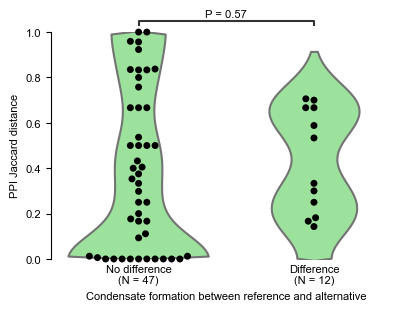

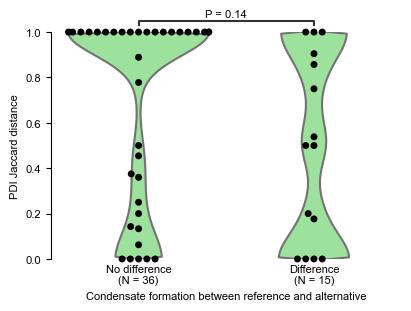

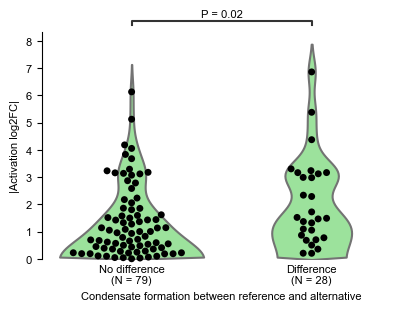

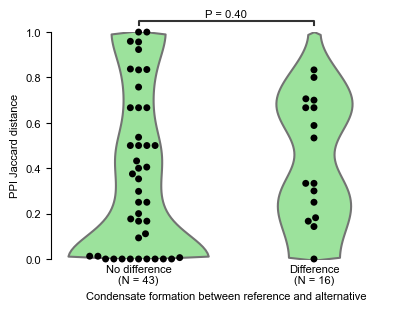

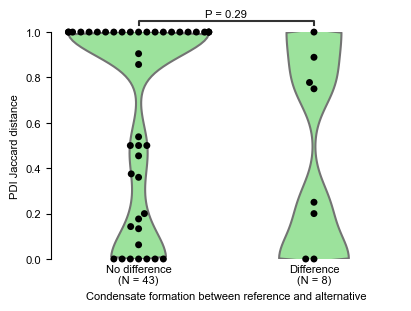

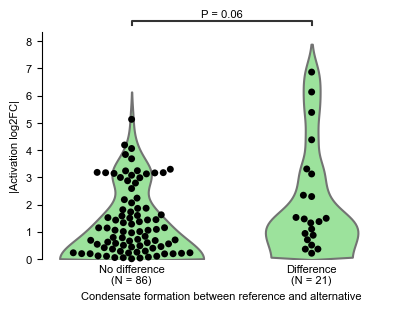

In [27]:
condensate_violin_plot(var='PPI_Jaccard_d', cl='HEK', xvar='condensate_cat_only')
condensate_violin_plot(var='PDI_Jaccard_d', cl='HEK', xvar='condensate_cat_only')
condensate_violin_plot(var='activation_abs_fold_change_log2', 
                       cl='HEK',
                       ub=1000,
                       bw=0.5,
                       xvar='condensate_cat_only')

condensate_violin_plot(var='PPI_Jaccard_d', cl='U2OS', xvar='condensate_cat_only')
condensate_violin_plot(var='PDI_Jaccard_d', cl='U2OS', xvar='condensate_cat_only')
condensate_violin_plot(var='activation_abs_fold_change_log2', 
                       cl='U2OS',
                       ub=1000,
                       bw=0.5,
                       xvar='condensate_cat_only')

In [28]:
pairs['localization_HEK_ref'].value_counts()

both         66
nucleus      51
cytoplasm    12
Name: localization_HEK_ref, dtype: int64

In [29]:
(pairs.groupby(['localization_HEK_ref', 'localization_HEK_alt'])
 .size()
 .reset_index()
 .pivot(values=0,
        index='localization_HEK_ref',
        columns='localization_HEK_alt')
 .fillna(0)
 .astype(int)
 .iloc[::-1, ::-1]
        )

localization_HEK_alt,nucleus,cytoplasm,both
localization_HEK_ref,,,
nucleus,26,3,22
cytoplasm,2,6,4
both,8,6,52


In [30]:
(pairs.groupby(['localization_U2OS_ref', 'localization_U2OS_alt'])
 .size()
 .reset_index()
 .pivot(values=0,
        index='localization_U2OS_ref',
        columns='localization_U2OS_alt')
 .fillna(0)
 .astype(int)
 .iloc[::-1, ::-1]
        )

localization_U2OS_alt,nucleus,cytoplasm,both
localization_U2OS_ref,,,
nucleus,28,4,21
cytoplasm,0,6,3
both,10,7,50


In [31]:
pairs['localization_cat_HEK'].value_counts()

No difference    84
Difference       45
Name: localization_cat_HEK, dtype: int64

In [32]:
pairs['localization_cat_U2OS'].value_counts()

No difference    84
Difference       45
Name: localization_cat_U2OS, dtype: int64

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.51
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.44
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.12
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00

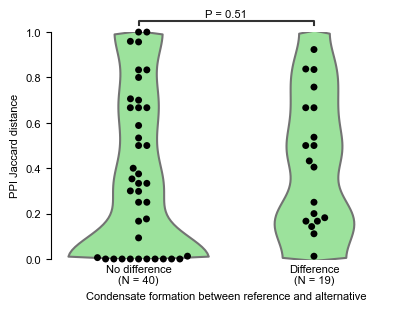

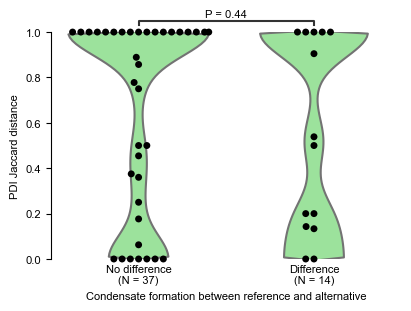

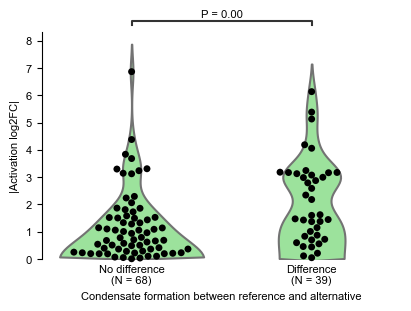

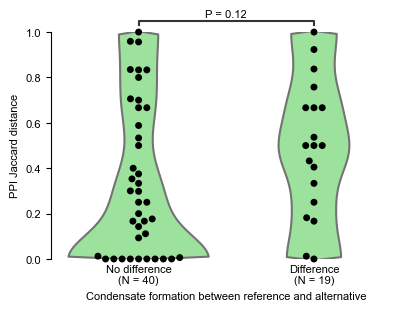

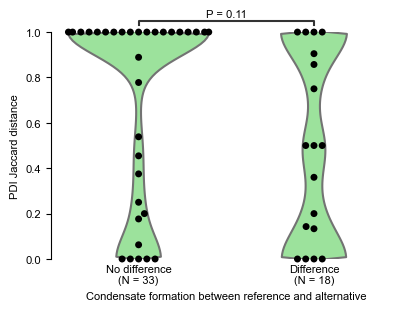

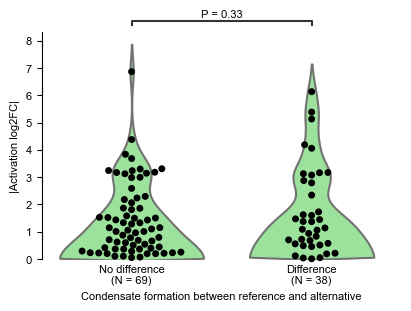

In [33]:
condensate_violin_plot(var='PPI_Jaccard_d', cl='HEK', xvar='localization_cat')
condensate_violin_plot(var='PDI_Jaccard_d', cl='HEK', xvar='localization_cat')
condensate_violin_plot(var='activation_abs_fold_change_log2', 
                       cl='HEK',
                       ub=1000,
                       bw=0.5,
                       xvar='localization_cat')

condensate_violin_plot(var='PPI_Jaccard_d', cl='U2OS', xvar='localization_cat')
condensate_violin_plot(var='PDI_Jaccard_d', cl='U2OS', xvar='localization_cat')
condensate_violin_plot(var='activation_abs_fold_change_log2', 
                       cl='U2OS',
                       ub=1000,
                       bw=0.5,
                       xvar='localization_cat')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.18


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.03


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.00


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.02


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.20
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.05


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


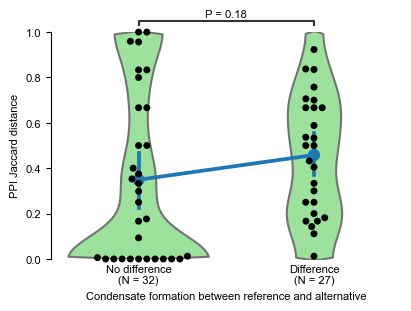

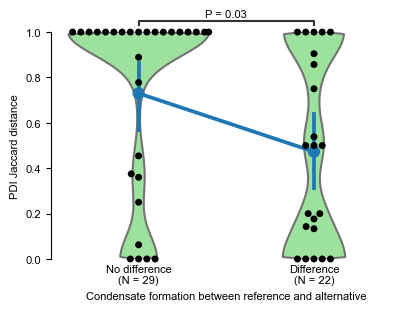

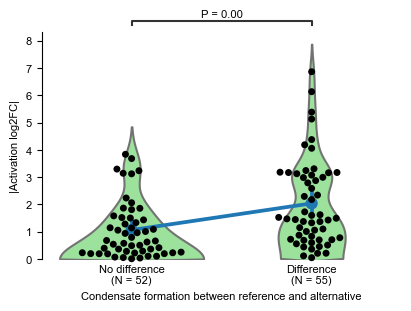

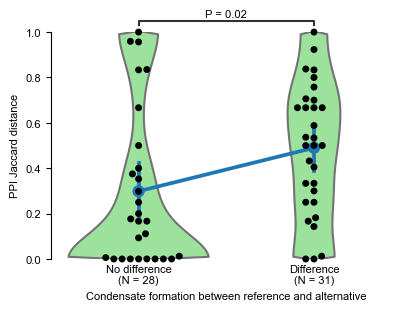

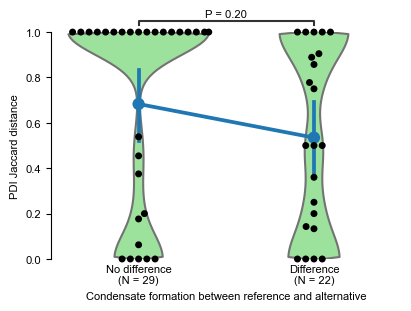

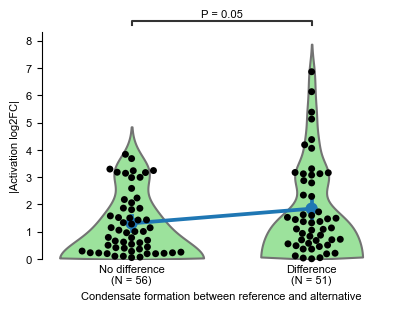

In [34]:
condensate_violin_plot(var='PPI_Jaccard_d', cl='HEK', xvar='condensate_or_loc_change', draw_mean=True)
condensate_violin_plot(var='PDI_Jaccard_d', cl='HEK', xvar='condensate_or_loc_change', draw_mean=True)
condensate_violin_plot(var='activation_abs_fold_change_log2', 
                       cl='HEK',
                       ub=1000,
                       bw=0.5,
                       xvar='condensate_or_loc_change',
                       draw_mean=True,
                       )

condensate_violin_plot(var='PPI_Jaccard_d', cl='U2OS', xvar='condensate_or_loc_change', draw_mean=True)
condensate_violin_plot(var='PDI_Jaccard_d', cl='U2OS', xvar='condensate_or_loc_change', draw_mean=True)
condensate_violin_plot(var='activation_abs_fold_change_log2', 
                       cl='U2OS',
                       ub=1000,
                       bw=0.5,
                       xvar='condensate_or_loc_change',
                       draw_mean=True)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.040
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.022
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.003


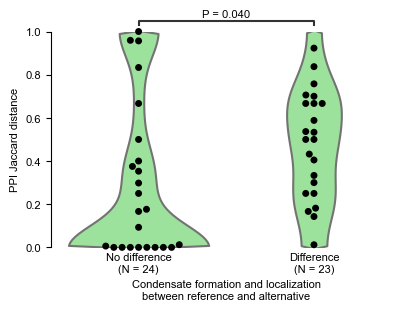

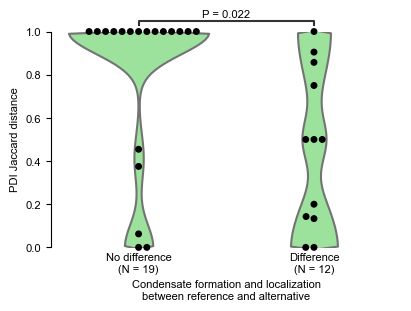

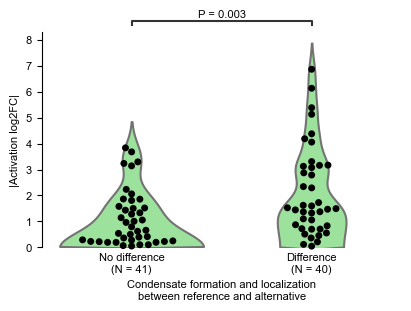

In [46]:
condensate_violin_plot(var='PPI_Jaccard_d', 
                       cl='both', 
                       xvar='condensate_or_loc_change', 
                       draw_mean=False,
                       xlabel='Condensate formation and localization\nbetween reference and alternative',
                       )
condensate_violin_plot(var='PDI_Jaccard_d',
                       cl='both',
                       xvar='condensate_or_loc_change',
                       draw_mean=False,
                       xlabel='Condensate formation and localization\nbetween reference and alternative',
)
condensate_violin_plot(var='activation_abs_fold_change_log2', 
                       cl='both',
                       ub=1000,
                       bw=0.5,
                       xvar='condensate_or_loc_change',
                       draw_mean=False,
                       xlabel='Condensate formation and localization\nbetween reference and alternative',
                       )

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.50


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.13
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.06


/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


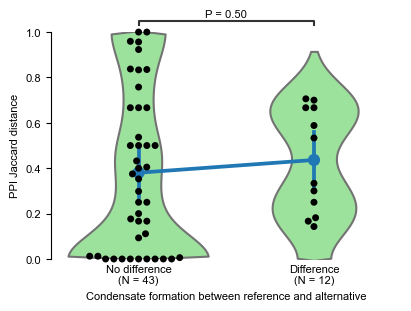

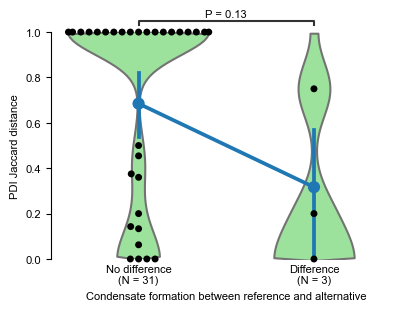

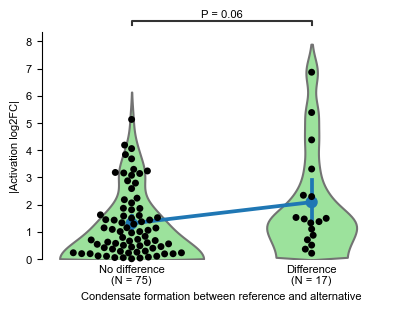

In [ ]:
condensate_violin_plot(var='PPI_Jaccard_d', cl='both', xvar='condensate_cat_only', draw_mean=True)
condensate_violin_plot(var='PDI_Jaccard_d', cl='both', xvar='condensate_cat_only', draw_mean=True)
condensate_violin_plot(var='activation_abs_fold_change_log2', 
                       cl='both',
                       ub=1000,
                       bw=0.5,
                       xvar='condensate_cat_only',
                       draw_mean=True,
                       )

In [ ]:
pairs.groupby(['condensate_or_loc_change_HEK', 
               'condensate_or_loc_change_U2OS']).size()

condensate_or_loc_change_HEK  condensate_or_loc_change_U2OS
Difference                    Difference                       49
                              No difference                    17
No difference                 Difference                       14
                              No difference                    49
dtype: int64

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.24


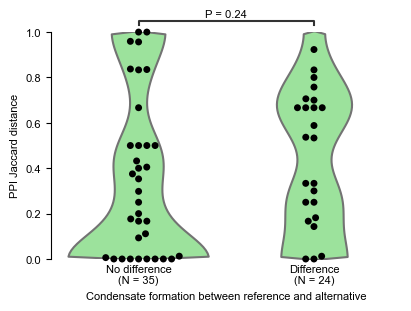

In [ ]:
condensate_violin_plot(var='PPI_Jaccard_d', cl='U2OS')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.04


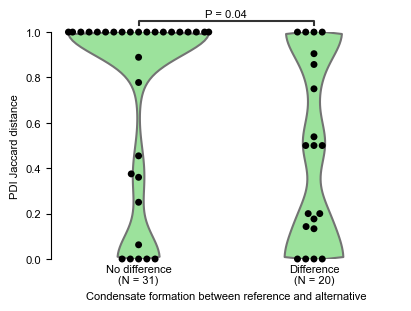

In [ ]:
condensate_violin_plot(var='PDI_Jaccard_d', cl='HEK')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.06


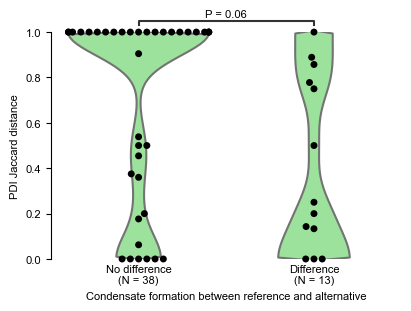

In [ ]:
condensate_violin_plot(var='PDI_Jaccard_d', cl='U2OS')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.00


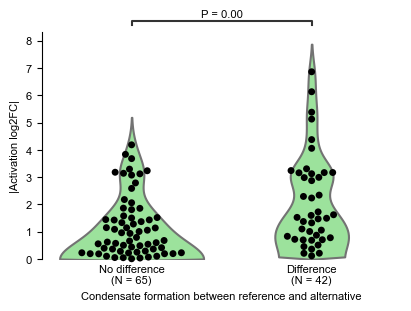

In [ ]:
condensate_violin_plot(var='activation_abs_fold_change_log2', 
                       cl='HEK',
                       ub=1000,
                       bw=0.5,
                       )

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

No difference vs. Difference: P = 0.03


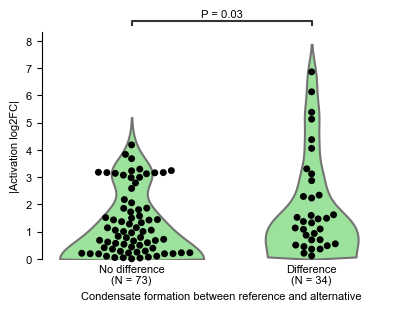

In [ ]:
condensate_violin_plot(var='activation_abs_fold_change_log2', 
                       cl='U2OS',
                       ub=1000,
                       bw=0.5,
                       )

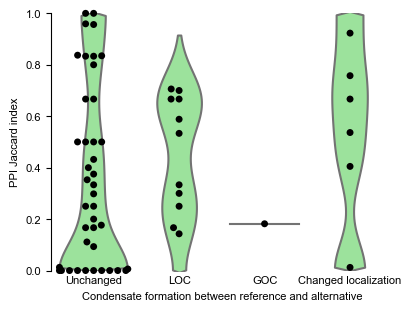

In [ ]:
# loss vs gain?

# loss should be due to loss of PPIs?
# loss shoudl lead to loss of activation?
var = 'PPI_Jaccard_d'
cl = 'HEK'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=4, h=3)
sns.swarmplot(data=pairs,
                     x=f'condensate_cat_{cl}',
                     y=var,
              #order=['Unchanged', 'Difference'],
              color='black',
              ax=ax,
              clip_on=False,)
violinplot_reflected(data=pairs,
                     x=f'condensate_cat_{cl}',
                     y=var,
                    inner=None,
              #cut=0,
              color='lightgreen',
              #order=['No difference', 'Difference'],
              ax=ax,
              )
ax.set_ylim(0, 1)
"""
pval = permutation_test(x, y)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])
"""
ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('PPI Jaccard index')
#ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
#                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0)
fig.savefig('../figures/PPI-Jaccard-vs-condensate-change_categories_boxplot.pdf',
            bbox_inches='tight')

/Users/lukelambourne/work/tf_isoforms/venv/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 12.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


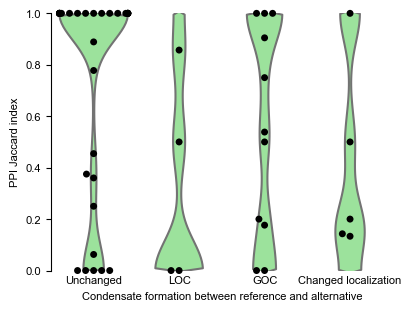

In [ ]:
# loss vs gain?

# loss should be due to loss of PPIs?
# loss shoudl lead to loss of activation?
var = 'PDI_Jaccard_d'
cl = 'HEK'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=4, h=3)
sns.swarmplot(data=pairs,
                     x=f'condensate_cat_{cl}',
                     y=var,
              #order=['Unchanged', 'Difference'],
              color='black',
              ax=ax,
              clip_on=False,)
violinplot_reflected(data=pairs,
                     x=f'condensate_cat_{cl}',
                     y=var,
                    inner=None,
              #cut=0,
              color='lightgreen',
              #order=['No difference', 'Difference'],
              ax=ax,
              )
ax.set_ylim(0, 1)
"""
pval = permutation_test(x, y)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])
"""
ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('PPI Jaccard index')
#ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
#                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0)
fig.savefig('../figures/PDI-Jaccard-vs-condensate-change_categories_boxplot.pdf',
            bbox_inches='tight')

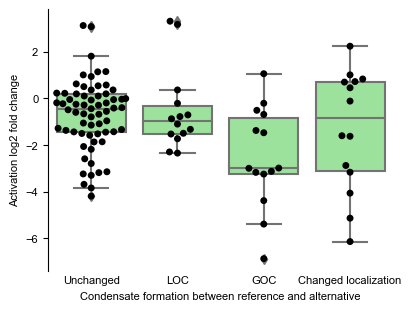

In [ ]:
# loss vs gain?

# loss should be due to loss of PPIs?
# loss shoudl lead to loss of activation?
var = 'activation_fold_change_log2'
cl = 'HEK'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=4, h=3)
sns.swarmplot(data=pairs,
                     x=f'condensate_cat_{cl}',
                     y=var,
              #order=['Unchanged', 'Difference'],
              color='black',
              ax=ax,
              clip_on=False,)
sns.boxplot(data=pairs,
                     x=f'condensate_cat_{cl}',
                     y=var,
              color='lightgreen',
              #order=['No difference', 'Difference'],
              ax=ax,
              )
"""
pval = permutation_test(x, y)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])
"""
ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('Activation log2 fold change')
#ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
#                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0)
fig.savefig(f'../figures/activation-vs-condensate-change_categories_{cl}_boxplot.pdf',
            bbox_inches='tight')

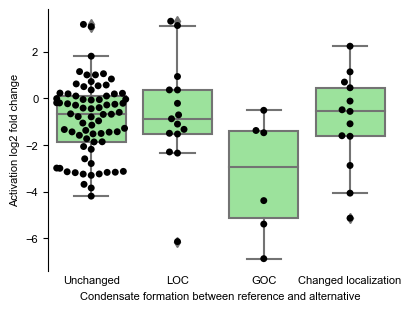

In [ ]:
# loss vs gain?

# loss should be due to loss of PPIs?
# loss shoudl lead to loss of activation?
var = 'activation_fold_change_log2'
cl = 'U2OS'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=4, h=3)
sns.swarmplot(data=pairs,
                     x=f'condensate_cat_{cl}',
                     y=var,
              #order=['Unchanged', 'Difference'],
              color='black',
              ax=ax,
              clip_on=False,)
sns.boxplot(data=pairs,
                     x=f'condensate_cat_{cl}',
                     y=var,
              color='lightgreen',
              #order=['No difference', 'Difference'],
              ax=ax,
              )
"""
pval = permutation_test(x, y)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])
"""
ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('Activation log2 fold change')
#ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
#                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0)
fig.savefig(f'../figures/activation-vs-condensate-change_categories_{cl}_boxplot.pdf',
            bbox_inches='tight')

In [ ]:
pairs.sort_values('activation_fold_change_log2').head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_identity,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,activation_abs_fold_change_log2,PPI_Jaccard_d,PDI_Jaccard_d,condensates_observed_HEK_ref,condensates_observed_U2OS_ref,HEK_Condensate_ref,U2OS_Condensate_ref,localization_HEK_ref,localization_U2OS_ref,condensates_observed_HEK_alt,condensates_observed_U2OS_alt,HEK_Condensate_alt,U2OS_Condensate_alt,localization_HEK_alt,localization_U2OS_alt,condensate_cat_HEK,condensate_cat_U2OS,condensate_cat_merged_HEK,condensate_cat_merged_U2OS,condensate_cat_only_HEK,condensate_cat_only_U2OS,localization_cat_HEK,localization_cat_U2OS,condensate_cat_only_detailed_HEK,condensate_cat_only_detailed_U2OS,combined_cat_HEK,combined_cat_U2OS,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS
114,TBPL1,ENSG00000028839,TBP,False,TBPL1|1/2|04H06,TBPL1|2/2|04A07,ENST00000237264|ENST00000613034,ENST00000367871,False,False,True,186,163,6,5,False,True,False,True,False,False,False,False,2.0,12.121212,True,86.559140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,7.110312,0.246030,-6.864281,6.864281,NaN,NaN,False,False,NaN,NaN,both,both,True,True,CC,BOTH,both,both,GOC,GOC,Difference,Difference,Difference,Difference,No difference,No difference,Alernative gains condensate,Alernative gains condensate,Difference in condensate formation,Difference in condensate formation,None -> CC,None -> BOTH
163,TFEC,ENSG00000105967,bHLH,True,TFEC|1/6|03F07,TFEC|3/6|03C11,ENST00000265440,ENST00000484212,False,False,True,347,316,7,7,True,True,False,True,True,False,False,False,0.0,0.000000,False,50.800915,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,6.330644,0.198317,-6.132327,6.132327,NaN,NaN,True,True,NC,NC,nucleus,nucleus,True,False,CC,NaN,both,both,Changed localization,LOC,Difference,Difference,No difference,Difference,Difference,Difference,Both form condensates,Alternative loses condensate,Difference in localization,Difference in both,NC -> CC,NC -> None
240,FOXJ2,ENSG00000065970,Forkhead,False,FOXJ2|1/2|06F10,FOXJ2|2/2|06B11,ENST00000162391,ENST00000428177,False,False,True,574,526,10,8,False,True,False,True,False,False,False,False,0.0,0.000000,False,89.721254,2.0,0.0,2.0,2.0,0.0,0.0,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,True,6.550576,1.167440,-5.383136,5.383136,NaN,NaN,False,False,NaN,NaN,nucleus,nucleus,True,True,CC,BOTH,both,both,GOC,GOC,Difference,Difference,Difference,Difference,Difference,Difference,Alernative gains condensate,Alernative gains condensate,Difference in both,Difference in both,None -> CC,None -> BOTH
166,TFEC,ENSG00000105967,bHLH,True,TFEC|1/6|03F07,TFEC|6/6|03E11,ENST00000265440,NaN,False,True,True,347,196,7,5,False,True,True,True,True,True,False,False,1.0,3.703704,True,55.331412,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,6.330644,1.201684,-5.128960,5.128960,NaN,NaN,True,True,NC,NC,nucleus,nucleus,True,True,CC,CC,both,both,Changed localization,Changed local

In [ ]:
pairs.sort_values('activation_fold_change_log2', ascending=False).head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_identity,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,activation_abs_fold_change_log2,PPI_Jaccard_d,PDI_Jaccard_d,condensates_observed_HEK_ref,condensates_observed_U2OS_ref,HEK_Condensate_ref,U2OS_Condensate_ref,localization_HEK_ref,localization_U2OS_ref,condensates_observed_HEK_alt,condensates_observed_U2OS_alt,HEK_Condensate_alt,U2OS_Condensate_alt,localization_HEK_alt,localization_U2OS_alt,condensate_cat_HEK,condensate_cat_U2OS,condensate_cat_merged_HEK,condensate_cat_merged_U2OS,condensate_cat_only_HEK,condensate_cat_only_U2OS,localization_cat_HEK,localization_cat_U2OS,condensate_cat_only_detailed_HEK,condensate_cat_only_detailed_U2OS,combined_cat_HEK,combined_cat_U2OS,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS
49,ATF2,ENSG00000115966,bZIP,True,ATF2|1/6|12H04,ATF2|5/6|09A05,ENST00000264110|ENST00000392544,ENST00000409833,False,False,True,505,209,12,6,False,True,False,True,False,False,False,False,0.0,100.000000,True,41.386139,3.0,1.0,3.0,3.0,1.0,1.0,2.0,-2.0,0.333333,loses all,retains all,loses all,NaN,retains all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.361183,3.668095,3.306912,3.306912,0.666667,NaN,True,True,CC,CC,both,both,False,False,NaN,NaN,both,both,LOC,LOC,Difference,Difference,Difference,Difference,No difference,No difference,Alternative loses condensate,Alternative loses condensate,Difference in condensate formation,Difference in condensate formation,CC -> None,CC -> None
368,ZNF473,ENSG00000142528,C2H2 ZF,False,ZNF473|1/2|10F12,ZNF473|2/2|01B08,ENST00000270617|ENST00000391821|ENST00000595661,ENST00000601364,False,False,True,871,77,4,4,False,True,False,False,False,False,False,False,0.0,100.000000,True,8.610792,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,7.223517,10.394043,3.170526,3.170526,NaN,NaN,True,True,NC,NC,nucleus,nucleus,False,True,NaN,NC,both,both,LOC,Unchanged,Difference,No difference,Difference,No difference,Difference,Difference,Alternative loses condensate,Both form condensates,Difference in both,Difference in localization,NC -> None,NC -> NC
40,DLX1,ENSG00000144355,Homeodomain,False,DLX1|1/2|07A12,DLX1|2/2|07E09,ENST00000361725,ENST00000341900,False,False,True,255,129,3,2,False,True,True,True,False,True,False,False,0.0,100.000000,True,43.023256,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,0.0,3.0,3.0,0.0,0.0,0.0,True,0.800854,3.922978,3.122124,3.122124,NaN,1.0,False,True,NaN,CC,both,both,False,False,NaN,NaN,both,both,Unchanged,LOC,No difference,Difference,No difference,Difference,No difference,No difference,Neither form condensates,Alternative loses condensate,Same localization and condensate formation,Difference in condensate formation,None -> None,CC -> None
46,E2F6,ENSG00000169016,E2F,True,E2F6|1/2|10C02,E2F6|2/2|01A04,ENST00000381525,ENST00000542100|ENST00000546212,False,False,True,281,206,7,5,True,False,False,False,True,False,False,False,0.0,18.461538,True,73.309609,2.0,0.0,2.0,2.0,0.0,0.0,2.0,-2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [ ]:
pairs.sort_values('gene_symbol').to_csv('../output/TF-iso_condensates_ref-vs-alt.tsv', sep='\t', index=False)

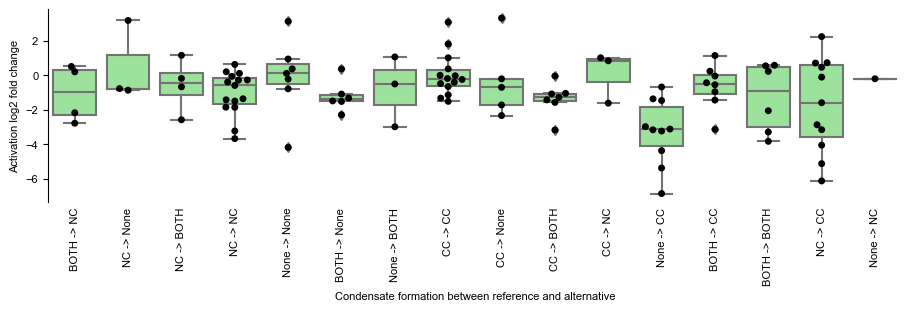

In [ ]:
# loss vs gain?

# loss should be due to loss of PPIs?
# loss shoudl lead to loss of activation?
var = 'activation_fold_change_log2'
cl = 'HEK'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=9, h=3)
sns.swarmplot(data=pairs,
                     x=f'condensate_cat_detailed_{cl}',
                     y=var,
              #order=['Unchanged', 'Difference'],
              color='black',
              ax=ax,
              clip_on=False,)
sns.boxplot(data=pairs,
                     x=f'condensate_cat_detailed_{cl}',
                     y=var,
              color='lightgreen',
              #order=['No difference', 'Difference'],
              ax=ax,
              )
"""
pval = permutation_test(x, y)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])
"""
ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('Activation log2 fold change')
#ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
#                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0, rotation=90)
fig.savefig(f'../figures/activation-vs-condensate-change_categories-detailed_{cl}_boxplot.pdf',
            bbox_inches='tight')

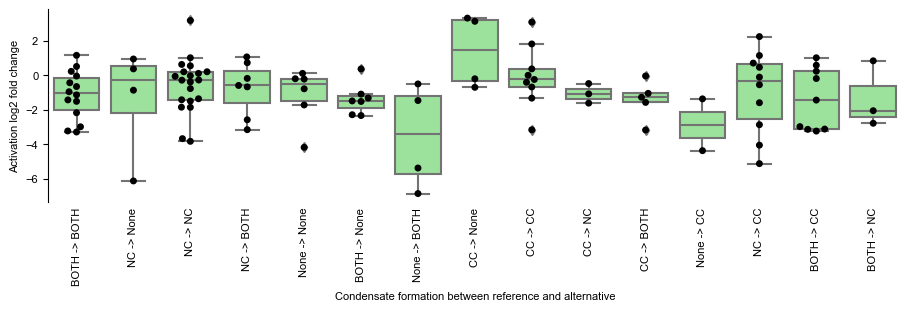

In [ ]:
# loss vs gain?

# loss should be due to loss of PPIs?
# loss shoudl lead to loss of activation?
var = 'activation_fold_change_log2'
cl = 'U2OS'

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=9, h=3)
sns.swarmplot(data=pairs,
                     x=f'condensate_cat_detailed_{cl}',
                     y=var,
              #order=['Unchanged', 'Difference'],
              color='black',
              ax=ax,
              clip_on=False,)
sns.boxplot(data=pairs,
                     x=f'condensate_cat_detailed_{cl}',
                     y=var,
              color='lightgreen',
              #order=['No difference', 'Difference'],
              ax=ax,
              )
"""
pval = permutation_test(x, y)
annotator = Annotator(ax=ax, pairs=[('No difference', 'Difference')], data=pairs, x='condensate_cat_merged', y=var, order=['No difference', 'Difference'],)
annotator.configure(loc='outside')
annotator.annotate_custom_annotations(['P = {:.2f}'.format(pval)])
"""
ax.set_xlabel('Condensate formation between reference and alternative')
for loc in ['right', 'top', 'bottom']:
    ax.spines[loc].set_visible(False)
ax.set_ylabel('Activation log2 fold change')
#ax.set_xticklabels(['No difference\n(N = {})'.format(x.shape[0]),
#                    'Difference\n(N = {})'.format(y.shape[0])])
ax.xaxis.set_tick_params(length=0, rotation=90)
fig.savefig(f'../figures/activation-vs-condensate-change_categories-detailed_{cl}_boxplot.pdf',
            bbox_inches='tight')

- CREB1 - the alternative isoform, with a small insertion, forms nuclear condensates (and doesn't bind DNA...)
- TBX5 - alternative isoforms form cytoplasmic condensates. TBX5-3, which doesn't activate, doesn't seem to be in the nucleus...
- ZIC3 - novel isoforms form condensates
- **PBX1** - ref forms condensates in both nucleus and cytoplasm. alt looses them

In [ ]:
pairs.loc[pairs['gene_symbol'] == 'FOXP2', :]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_identity,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,activation_abs_fold_change_log2,PPI_Jaccard_d,PDI_Jaccard_d,condensates_observed_HEK_ref,condensates_observed_U2OS_ref,HEK_Condensate_ref,U2OS_Condensate_ref,localization_HEK_ref,localization_U2OS_ref,condensates_observed_HEK_alt,condensates_observed_U2OS_alt,HEK_Condensate_alt,U2OS_Condensate_alt,localization_HEK_alt,localization_U2OS_alt,condensate_cat_HEK,condensate_cat_U2OS,condensate_cat_merged_HEK,condensate_cat_merged_U2OS,condensate_cat_only_HEK,condensate_cat_only_U2OS,localization_cat_HEK,localization_cat_U2OS,condensate_cat_only_detailed_HEK,condensate_cat_only_detailed_U2OS,combined_cat_HEK,combined_cat_U2OS,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS
149,FOXP2,ENSG00000128573,Forkhead,False,FOXP2|2/10|07B01,FOXP2|1/10|07C01,ENST00000350908|ENST00000393494,ENST00000408937,False,False,True,715,740,16,17,False,False,True,False,False,False,False,False,0.0,0.0,False,96.486486,12.0,15.0,15.0,12.0,15.0,12.0,3.0,3.0,0.800000,NaN,gains some,gains some,retains all,retains all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.640735,3.043575,-0.597160,0.597160,0.200000,NaN,True,True,NC,NC,both,both,True,True,NC,BOTH,nucleus,both,Unchanged,Unchanged,No difference,No difference,No difference,No difference,Difference,No difference,Both form condensates,Both form condensates,Difference in localization,Same localization and condensate formation,NC -> NC,NC -> BOTH
150,FOXP2,ENSG00000128573,Forkhead,False,FOXP2|2/10|07B01,FOXP2|4/10|12A06,ENST00000350908|ENST00000393494,ENST00000393489,False,False,True,715,623,16,14,True,False,False,False,True,False,False,False,0.0,0.0,False,87.132867,12.0,11.0,12.0,11.0,11.0,10.0,2.0,0.0,0.833333,NaN,loses some,loses some,retains all,retains all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,3.640735,2.212872,-1.427863,1.427863,0.166667,NaN,True,True,NC,NC,both,both,True,True,NC,NC,nucleus,both,Unchanged,Unchanged,No difference,No difference,No difference,No difference,Difference,No difference,Both form condensates,Both form condensates,Difference in localization,Same localization and condensate formation,NC -> NC,NC -> NC
151,FOXP2,ENSG00000128573,Forkhead,False,FOXP2|2/10|07B01,FOXP2|10/10|06A10,ENST00000350908|ENST00000393494,ENST00000462331,False,False,True,715,67,16,2,False,True,False,False,False,False,False,False,0.0,100.0,True,7.960894,12.0,0.0,12.0,12.0,0.0,0.0,12.0,-12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,True,3.640735,5.876355,2.235620,2.235620,NaN,NaN,True,True,NC,NC,both,both,True,True,CC,CC,both,both,Changed localization,Changed localization,Difference,Difference,No difference,No difference,No difference,No difference,Both form condensates,Both form condensates,Same localization and condensate formation,Same localization and condensate formation,NC -> CC,NC -> CC
152,FOXP2,ENSG00000128573,Forkhead,False,FOXP2|2/10|07B01,FOXP2|6/10|06F12,ENST00000350908|ENST00000393494,NaN,False,True,True,715,450,16,10,False,True,True,True,False,False,False,False

In [ ]:
pairs.loc[pairs['gene_symbol'] == 'PBX1', :]

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_identity,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,activation_abs_fold_change_log2,PPI_Jaccard_d,PDI_Jaccard_d,condensates_observed_HEK_ref,condensates_observed_U2OS_ref,HEK_Condensate_ref,U2OS_Condensate_ref,localization_HEK_ref,localization_U2OS_ref,condensates_observed_HEK_alt,condensates_observed_U2OS_alt,HEK_Condensate_alt,U2OS_Condensate_alt,localization_HEK_alt,localization_U2OS_alt,condensate_cat_HEK,condensate_cat_U2OS,condensate_cat_merged_HEK,condensate_cat_merged_U2OS,condensate_cat_only_HEK,condensate_cat_only_U2OS,localization_cat_HEK,localization_cat_U2OS,condensate_cat_only_detailed_HEK,condensate_cat_only_detailed_U2OS,combined_cat_HEK,combined_cat_U2OS,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS
20,PBX1,ENSG00000185630,Homeodomain,False,PBX1|1/2|02A05,PBX1|2/2|02C05,ENST00000420696,ENST00000367897,False,False,True,430,347,9,7,False,True,True,True,False,True,False,False,0.0,0.0,False,77.314815,10.0,7.0,10.0,10.0,7.0,7.0,3.0,-3.0,0.7,NaN,loses some,loses some,retains all,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,True,1.996387,0.896866,-1.099522,1.099522,0.3,NaN,True,True,BOTH,BOTH,both,both,False,False,NaN,NaN,both,both,LOC,LOC,Difference,Difference,Difference,Difference,No difference,No difference,Alternative loses condensate,Alternative loses condensate,Difference in condensate formation,Difference in condensate formation,BOTH -> None,BOTH -> None


In [ ]:
from data_loading import load_annotated_TFiso1_collection

tfs = load_annotated_TFiso1_collection()

reading from cache


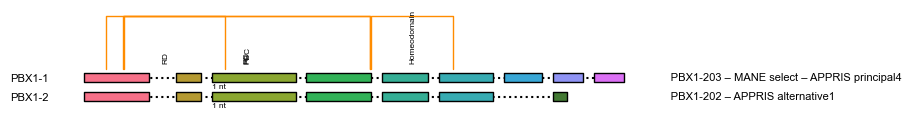

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=9, h=1.1)
tfs['PBX1'].exon_diagram(show_uncloned_isoforms=False,
                         show_domains=True,
                         ax=ax)
fig.savefig('../figures/PBX1_cloned_isoforms_exon-diagram.pdf', bbox_inches='tight')

In [ ]:
tfs['PBX1']['PBX1-1'].aa_seq_features

[Pfam_domain: PF03792 PBC 40-232,
 Pfam_domain: PF00046 Homeodomain 234-293,
 DBD_flank: PF00046_flank_N N_DBD_flank 219-233,
 DBD_flank: PF00046_flank_C C_DBD_flank 294-308,
 effector_domain: Soto_Effector 0541 RD 39-232,
 effector_domain: DelRosso_RD_PBX1_1 RD 22-101]

In [ ]:
# check the NLS position
# The FOXP2 NLS is not annotated in UniProt, but is 
# reported in 
# Mizutani A, Matsuzaki A, Momoi MY, Fujita E, Tanabe Y, Momoi T. 
# Intracellular distribution of a speech/language disorder associated FOXP2 mutant. 
# Biochem Biophys Res Commun. 2007 Feb 23;353(4):869–874. PMID: 17196932

# They report two NLS flanking the forkhead DBD
# RRRHS at the N-terminal side and KRRSQK at the C-terminal side
# forkhead is 503-584
nls_1_start = tfs['FOXP2']['FOXP2-2'].aa_seq.find('RRRHS')
nls_2_start = tfs['FOXP2']['FOXP2-2'].aa_seq.find('KRRSQK')
tfs['FOXP2']['FOXP2-2'].add_aa_seq_feature(
    category="NLS",
    name="NLS",
    accession="NLS_1",
    start=nls_1_start,
    end=nls_1_start + len('RRRHS'),
    description='NLS from Mizutani et al.',
)
tfs['FOXP2']['FOXP2-2'].add_aa_seq_feature(
    category="NLS",
    name="NLS",
    accession="NLS_2",
    start=nls_2_start,
    end=nls_2_start + len('KRRSQK'),
    description='NLS from Mizutani et al.',
)

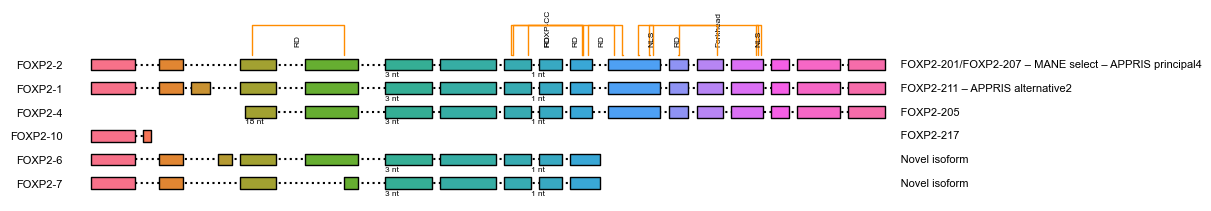

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=12, h=2)
tfs['FOXP2'].exon_diagram(show_uncloned_isoforms=False,
                          show_domains=True,
                          ax=ax)
fig.savefig('../figures/FOXP2_cloned_isoforms_exon-diagram.pdf', bbox_inches='tight')

In [ ]:
# look at NLS and NES
from data_loading import load_annotated_TFiso1_collection


tfs = load_annotated_TFiso1_collection()
nls = pd.concat(tf.aa_feature_disruption(tf.cloned_reference_isoform.name) for tf in tfs.values())
nls = nls.loc[nls['category'] == 'UniProt motif', :]
nls['clone_acc_alt'] = nls['alt_iso'].map(
    {iso.name: iso.clone_acc 
     for tf in tfs.values() 
     for iso in tf.cloned_isoforms}
    )
nls['type'] = nls['accession'].apply(lambda x: x.split('_')[0])
nls['affected'] = (nls['deletion'] + nls['insertion'] + nls['frameshift']) > 0 
pairs['NLS_affected'] = pairs['clone_acc_alt'].map(
    nls.loc[nls['type'] == 'NLS', :]
    .groupby('clone_acc_alt')
    ['affected']
    .any()
    )
pairs['NES_affected'] = pairs['clone_acc_alt'].map(
    nls.loc[nls['type'] == 'NES', :]
    .groupby('clone_acc_alt')
    ['affected']
    .any()
    )

reading from cache


In [ ]:
pairs['NLS_affected'].value_counts()

True     8
False    6
Name: NLS_affected, dtype: int64

In [ ]:
pairs['NES_affected'].value_counts()

True     5
False    1
Name: NES_affected, dtype: int64

In [ ]:
pairs.head()

,gene_symbol,Ensembl_gene_ID,family,is_dimerizing_TF_family,clone_acc_ref,clone_acc_alt,Ensembl_transcript_IDs_ref,Ensembl_transcript_IDs_alt,is_ref_novel_isoform,is_alt_novel_isoform,is_MANE_select_isoform_cloned,n_aa_ref,n_aa_alt,n_exons_ref,n_exons_alt,is_alternative_N_terminal,is_alternative_C_terminal,is_alternative_internal_exon,is_alternative_5_prime_donor,is_alternative_3_prime_acceptor,is_exon_skipping,is_mutually_exclusive_exons,is_intron_retention,dbd_insertion_n_aa,dbd_pct_lost,dbd_affected,aa_seq_pct_identity,n_positive_PPI_ref,n_positive_PPI_alt,n_PPI_successfully_tested_in_ref_and_alt,n_positive_PPI_ref_filtered,n_positive_PPI_alt_filtered,n_shared_PPI,n_PPI_diff,PPI_delta_n,PPI_jaccard,dimer_ppi,other_than_dimer_ppi,tf_tf_ppi,tf_cofactor_ppi,tf_signalling_ppi,n_positive_PDI_ref,n_positive_PDI_alt,n_PDI_successfully_tested_in_ref_and_alt,n_positive_PDI_ref_filtered,n_positive_PDI_alt_filtered,n_shared_PDI,PDI_jaccard,at_least_one_isoform_in_gene_abs_activation_gte_2fold,activation_ref,activation_alt,activation_fold_change_log2,activation_abs_fold_change_log2,PPI_Jaccard_d,PDI_Jaccard_d,condensates_observed_HEK_ref,condensates_observed_U2OS_ref,HEK_Condensate_ref,U2OS_Condensate_ref,localization_HEK_ref,localization_U2OS_ref,condensates_observed_HEK_alt,condensates_observed_U2OS_alt,HEK_Condensate_alt,U2OS_Condensate_alt,localization_HEK_alt,localization_U2OS_alt,condensate_cat_HEK,condensate_cat_U2OS,condensate_cat_merged_HEK,condensate_cat_merged_U2OS,condensate_cat_only_HEK,condensate_cat_only_U2OS,localization_cat_HEK,localization_cat_U2OS,condensate_cat_only_detailed_HEK,condensate_cat_only_detailed_U2OS,combined_cat_HEK,combined_cat_U2OS,condensate_cat_detailed_HEK,condensate_cat_detailed_U2OS,NLS_affected,NES_affected
0,ZBTB18,ENSG00000179456,C2H2 ZF,False,ZBTB18|1/2|04E08,ZBTB18|2/2|12E05,ENST00000358704,ENST00000622512,False,False,True,531,522,2,1,True,False,False,False,True,False,False,False,0.0,0.0,False,98.116761,4.0,4.0,5.0,4.0,4.0,3.0,2.0,0.0,0.6,NaN,loses some,loses some,retains all,retains all,0.0,1.0,1.0,0.0,1.0,0.0,0.0,True,2.153413,2.656826,0.503414,0.503414,0.4,1.0,True,True,BOTH,BOTH,both,both,True,True,NC,BOTH,both,both,Unchanged,Unchanged,No difference,No difference,No difference,No difference,No difference,No difference,Both form condensates,Both form condensates,Same localization and condensate formation,Same localization and condensate formation,BOTH -> NC,BOTH -> BOTH,NaN,NaN
1,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|1/3|09C07,ENST00000239461,ENST00000367760,False,False,True,245,217,4,4,False,True,False,False,False,False,False,False,0.0,0.0,False,82.040816,0.0,13.0,13.0,0.0,13.0,0.0,13.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,11.0,NaN,NaN,NaN,NaN,NaN,NaN,True,1.552087,0.679816,-0.872271,0.872271,NaN,NaN,True,True,NC,NC,nucleus,nucleus,False,False,NaN,NaN,both,nucleus,LOC,LOC,Difference,Difference,Difference,Difference,Difference,No difference,Alternative loses condensate,Alternative loses condensate,Difference in both,Difference in condensate formation,NC -> None,NC -> None,NaN,NaN
2,PRRX1,ENSG00000116132,Homeodomain,False,PRRX1|2/3|09F06,PRRX1|3/3|09H08,ENST00000239461,ENST00000497230,False,False,True,245,200,4,3,False,True,False,True,False,False,False,False,0.0,0.0,False,81.224490,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0,9.0,9.0,9.0,9.0,9.0,1.0,True,1.552087,0.773129,-0.778958,0.778958,NaN,0.0,True,True,NC,NC,nucleus,nucleus,False,True,NaN,NC,nucleus,nucleus,LOC,Unchanged,Difference,No difference,Difference,No difference,No difference,No difference,Alternative loses condensate,Both form condensates,Difference in condensate formation,Same localization and condensate formation,NC -> None,NC -> NC,NaN,NaN
5,GRHL3,ENSG00000158055,Grainyhead,True,GRHL3|3/7|08G09,GRHL3|1/7|08E10,ENST00000361548,ENST00000350501,False,False,True,602,626,16,16,False,True,False,False,False,False,False,False,0.0,0.0,False,90.923567,2.0,0.0,2.0,2.0,0.0,0.0,2.0,-2.0,NaN,NaN,NaN,NaN,

In [ ]:
pairs.loc[pairs['NLS_affected'].notnull(),
          ['clone_acc_alt',
           'NLS_affected',
           'NES_affected',
           'HEK_Condensate_ref', 'HEK_Condensate_alt',
           'condensate_cat_HEK',
           'localization_HEK_ref', 'localization_HEK_alt']].sort_values('NLS_affected')

,clone_acc_alt,NLS_affected,NES_affected,HEK_Condensate_ref,HEK_Condensate_alt,condensate_cat_HEK,localization_HEK_ref,localization_HEK_alt
61,KLF7|3/8|10B10,False,NaN,CC,BOTH,Unchanged,both,both
64,KLF7|4/8|10E10,False,NaN,CC,BOTH,Unchanged,both,both
274,MAX|2/6|07F12,False,NaN,NaN,NC,GOC,nucleus,nucleus
337,TP53|2/2|02F03,False,False,BOTH,BOTH,Unchanged,both,both
438,ZIC3|3/3|09C04,False,NaN,NaN,CC,GOC,nucleus,both
439,ZIC3|1/3|09F05,False,NaN,NaN,NC,GOC,nucleus,nucleus
62,KLF7|5/8|11H02,True,NaN,CC,CC,Unchanged,both,both
63,KLF7|6/8|01D06,True,NaN,CC,BOTH,Unchanged,both,both
65,KLF7|7/8|10H08,True,NaN,CC,BOTH,Unchanged,both,both
66,KLF7|8/8|10D09,True,NaN,CC,CC,Unchanged,both,both


In [ ]:
pairs.loc[pairs['NES_affected'].notnull(),
          ['clone_acc_alt',
           'NLS_affected',
           'NES_affected',
           'HEK_Condensate_ref', 'HEK_Condensate_alt',
           'condensate_cat_HEK',
           'localization_HEK_ref', 'localization_HEK_alt']].sort_values('NLS_affected')

,clone_acc_alt,NLS_affected,NES_affected,HEK_Condensate_ref,HEK_Condensate_alt,condensate_cat_HEK,localization_HEK_ref,localization_HEK_alt
337,TP53|2/2|02F03,False,False,BOTH,BOTH,Unchanged,both,both
47,ATF2|2/6|09E05,NaN,True,CC,CC,Unchanged,both,both
48,ATF2|3/6|09C05,NaN,True,CC,NaN,LOC,both,both
49,ATF2|5/6|09A05,NaN,True,CC,NaN,LOC,both,both
50,ATF2|4/6|09B05,NaN,True,CC,CC,Unchanged,both,both
51,ATF2|6/6|09H03,NaN,True,CC,CC,Unchanged,both,both


In [ ]:
stats.fisher_exact([[0, 4], [2, 1]])

SignificanceResult(statistic=0.0, pvalue=0.14285714285714288)

In [ ]:
# look for PPIs with known phase separating proteins
from data_loading import load_y2h_isoform_data
y2h = load_y2h_isoform_data()
y2h.head()

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result
0,ATF2|1/6|12H04,ATF2,ATF2,True
3,ATF2|1/6|12H04,ATF2,FOSL2,NaN
4,ATF2|1/6|12H04,ATF2,JDP2,True
12,ATF2|2/6|09E05,ATF2,ATF2,True
15,ATF2|2/6|09E05,ATF2,FOSL2,NaN


In [ ]:
llps_proteins = {'FUS', 'EWS', 'TAF15', 'DDX4',
                 'BRD4', 'MED1',
                 'TFEB',
                 'YAP',}
y2h.loc[y2h['db_gene_symbol'].isin(llps_proteins), :]

,ad_clone_acc,ad_gene_symbol,db_gene_symbol,Y2H_result


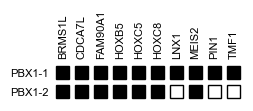

In [ ]:
from plotting import y2h_ppi_per_tf_gene_plot


fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=3, h=1)
y2h_ppi_per_tf_gene_plot(gene_name='PBX1', 
                         data=y2h,
                         ax=ax)
fig.savefig('../figures/PBX1_Y2H-matrix.pdf',
            bbox_inches='tight')

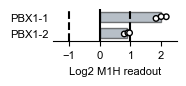

In [ ]:
# could also look for low complexity disordered regions
from data_loading import load_m1h_activation_data
from plotting import m1h_activation_per_tf_gene_plot

m1h = load_m1h_activation_data()
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=1.75, h=0.75)
m1h_activation_per_tf_gene_plot(tf_gene_name='PBX1',
                                data=m1h,
                                ax=ax,
                                xlim=(-1.5, 2.5),
)
ax.set_xticks(range(-1, 3))
fig.savefig('../figures/PBX1_M1H_bar.pdf', 
            bbox_inches='tight')

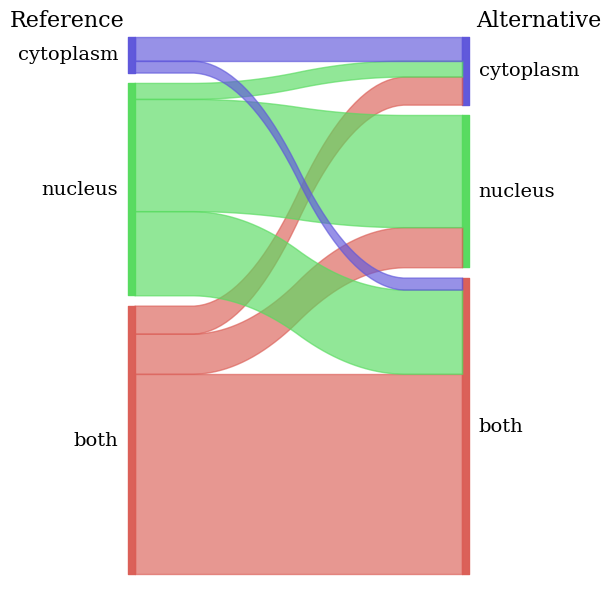

In [ ]:
# NOTE: I put this code at the end because it changes the matplotlib defaults
# so messes up the other plots
from pySankey import sankey

sankey.sankey(left=pairs.loc[pairs['localization_U2OS_alt'].notnull(), 'localization_U2OS_ref'],
              right=pairs.loc[pairs['localization_U2OS_alt'].notnull(), 'localization_U2OS_alt'])
plt.gca().text(x=-1, y=pairs.shape[0] * 1.05, s='Reference',
               fontsize=16,
               va='bottom',
               ha='right',)
plt.gca().text(x=35, y=pairs.shape[0] * 1.05, s='Alternative',
               fontsize=16,
               va='bottom',
               ha='left',)
plt.savefig('../figures/localization_ref-vs-alt_U2OS_Sankey.pdf',
            bbox_inches='tight')

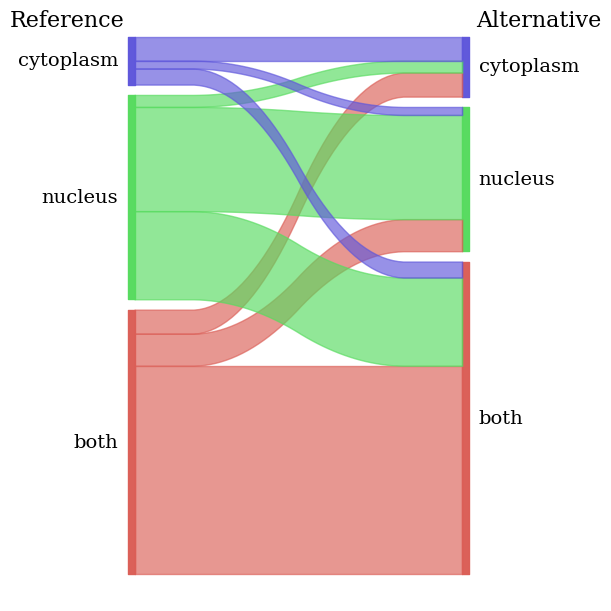

In [ ]:
sankey.sankey(left=pairs.loc[pairs['localization_HEK_alt'].notnull(), 'localization_HEK_ref'],
              right=pairs.loc[pairs['localization_HEK_alt'].notnull(), 'localization_HEK_alt'],
              )
plt.gca().text(x=-1, y=pairs.shape[0] * 1.05, s='Reference',
               fontsize=16,
               va='bottom',
               ha='right',)
plt.gca().text(x=35, y=pairs.shape[0] * 1.05, s='Alternative',
               fontsize=16,
               va='bottom',
               ha='left',)
plt.savefig('../figures/localization_ref-vs-alt_HEK_Sankey.pdf',
            bbox_inches='tight')